In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tool.utils import load_runs, load_experiments_df


In [2]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# sns.set(rc={'figure.figsize':(10,4)})


## Assumptions

In [21]:
from sklearn.linear_model import LinearRegression 

In [3]:
ts_runs_df = load_runs('time_series')

In [17]:
dataset_percentages = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mean_emissions = {}


for dataset_percentage in dataset_percentages:
    emissions = ts_runs_df.query(f"data_quality_dimension_percentage == {dataset_percentage}")[['emissions_kg']].mean()[0]
    mean_emissions[dataset_percentage] = emissions


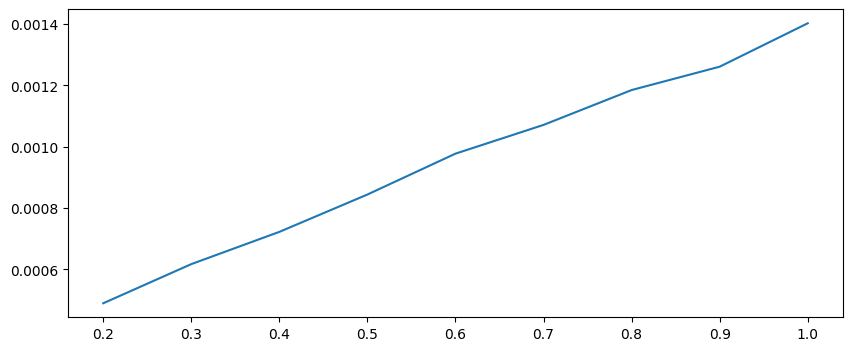

In [20]:
plt.plot(mean_emissions.keys(), mean_emissions.values())
plt.show()

In [69]:
reg = LinearRegression(fit_intercept=False).fit(np.array(list(mean_emissions.keys())).reshape(-1,1), list(mean_emissions.values()))


reg.coef_
reg.predict([[0]])

array([0.])

## Mathematical Analysis

Classic Method for hyperparameter search
- Using all of the data, test different models, evaluate and finally choose. 
- There are many methods for this
- Training and running 1 model is okay, in this phase more than 1000 runs may be done

Our Method
- Perform Hyperparameter search on a reduced set of the data, as usual
- Report results to our tool
- Perform a final and much shorter run of hyperparameter search on the reported results by our tool


- $N = $ Number of hyperparameter iterations performed on the classic method and first phase of our method
- $n = $ Number of hyperparameter search iterations performed on the second phase of out method
- $e = $ Emissions (Kg) of 1 run (training + testing a model) on 100% of the data available
- $t_i = $ Percent of dataset used for the first phase of our method (choosen by the user)
- $t_f = $ Percent of dataset used for the second phase of our method (reported by the tool)


Classic Method Emissions: $N*e$
Our Method Emissions: $N*e*t_i + n*e*t_f$


Percentual change of our method vs the classic method
$$100*\frac{N*e*t_i + n*e*t_f - N*e}{N*e}$$

With this formula, we can see two things based on the variable $N$:

**Break even point**: How many hyperparameter search iterations must be performed for our method to be more energy efficient than the classic method
$$N = \frac{t_f*n}{1-t_i}$$

To put this number into perspective, if we assume only 10 runs will be done in the second phase of hyperparameter search ($t_f$) in our method, the user used 0.5 of the dataset ($n$) for the initial results, we get the following results based on the tool reported $t_f$


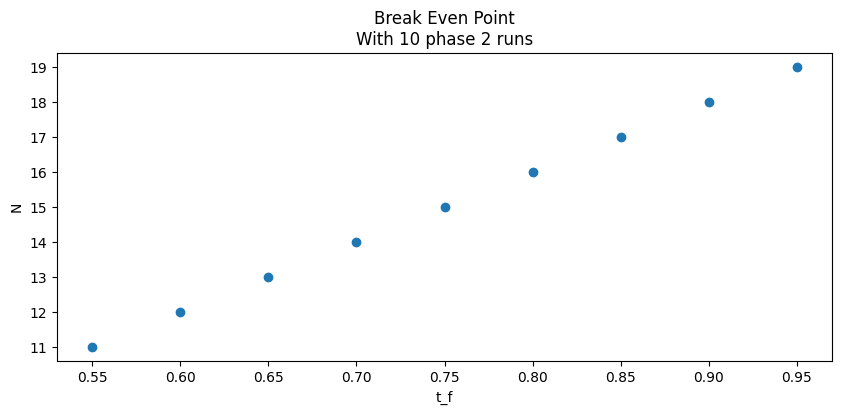

In [33]:
n = 10
t_i = 0.5
t_f = np.linspace(0.55, 0.95, 9)
N = t_f*n/(1-t_i)

plt.scatter(t_f, N)
plt.title(f"Break Even Point\nWith {n} phase 2 runs")
plt.xlabel('t_f')
plt.ylabel('N')
plt.show()

**Percentual Decrease Limit**: After N becomes big enough, the term $n*t_f*e$ (Emissions of the second phase of our method) becomes insignificant and the emissions are dominated by the term $t_i*e*N$. On the limit it can be shown that the percentual decrease reaches the value $t_i - 1$
- If the researcher used 0.4 percent of the dataset for the first part of our method, he would reduce his emissions by 60% by using our method compared to the classic method.


[ 0.02423544  0.04847087  0.09694174  0.19388349  0.38776697  0.77553394
  1.55106788  3.10213577  6.20427153 12.40854306]
[0.03862523 0.05074294 0.07497838 0.12344925 0.22039099 0.41427448
 0.80204145 1.57757539 3.12864327 6.23077904]
[ 0.59375     0.046875   -0.2265625  -0.36328125 -0.43164062 -0.46582031
 -0.48291016 -0.49145508 -0.49572754 -0.49786377]


C:\Users\marti\AppData\Local\Temp\ipykernel_28604\4230028015.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.array(N, dtype='str'), rotation = 45)


[Text(0, 0, '16'),
 Text(1, 0, '32'),
 Text(2, 0, '64'),
 Text(3, 0, '128'),
 Text(4, 0, '256'),
 Text(5, 0, '512'),
 Text(6, 0, '1024'),
 Text(7, 0, '2048'),
 Text(8, 0, '4096'),
 Text(9, 0, '8192')]

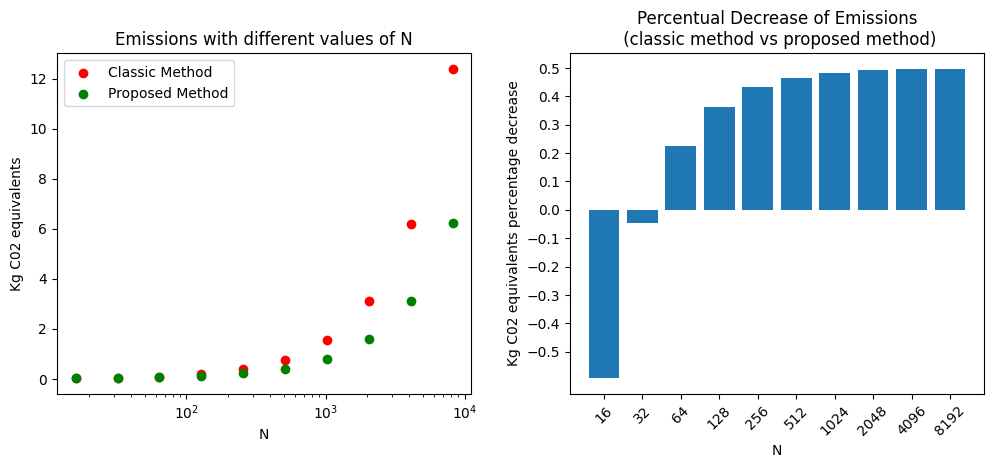

In [78]:
e = 1
def e(t):
    return reg.predict([[t]])[0] 

t_i = 0.5
N = 2**np.arange(4, 14)

# Irrelevant terms in the limit
n = 25
t_f = 0.7 

classic_method_emissions = N*e(1)
our_method_emissions = N*e(t_i) + n*e(t_f)
percentual_change = (our_method_emissions - classic_method_emissions)/classic_method_emissions


print(classic_method_emissions)
print(our_method_emissions)
print(percentual_change)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(w_pad=4.0)
# fig.suptitle(f"Percentual Change Limit")

ax1.scatter(N, classic_method_emissions, c='r', label='Classic Method')
ax1.scatter(N, our_method_emissions, c='g', label='Proposed Method')
ax1.set_xscale('log')
ax1.set_title('Emissions with different values of N')
ax1.set_xlabel('N')
ax1.set_ylabel('Kg C02 equivalents')
ax1.legend()

ax2.bar(np.array(N, dtype='str'), -percentual_change)
ax2.set_title('Percentual Decrease of Emissions\n (classic method vs proposed method)')
ax2.set_xlabel('N')
ax2.set_ylabel('Kg C02 equivalents percentage decrease')

start, end = ax2.get_ylim()
ax2.yaxis.set_ticks(np.arange(-0.5, 0.6, 0.1))

ax2.set_xticklabels(np.array(N, dtype='str'), rotation = 45)

In [63]:
(-0.5*reg.coef_[0])/(reg.intercept_ + reg.coef_[0])

-0.40063807459538964